In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
import gensim
from datasets import Dataset
import spacy
import core.model_utils as model_utils
import core.constants as constants
import matplotlib.pyplot as plt
import os
import re

In [2]:
spacy_model = spacy.load("pl_core_news_sm")

# Stop words
stop_words = spacy_model.Defaults.stop_words.copy()
stop_words.remove("nie")

# Punctuation
punctuations = string.punctuation


# Tokenizer
def spacy_tokenizer(sentence):
    doc = spacy_model(sentence)

    # Lemmatizing each token and converting each token into lowercase
    my_tokens = [ word.lemma_.lower().strip() for word in doc ]

    # Removing stop words and punctuation
    my_tokens = [ word for word in my_tokens if word not in stop_words and word not in punctuations ]
    return my_tokens


df = pd.read_json('./../data/polish_translated/emotions/assignments_dataset.json')

In [3]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

df = df.replace({"emotion": ordered_class_labels})

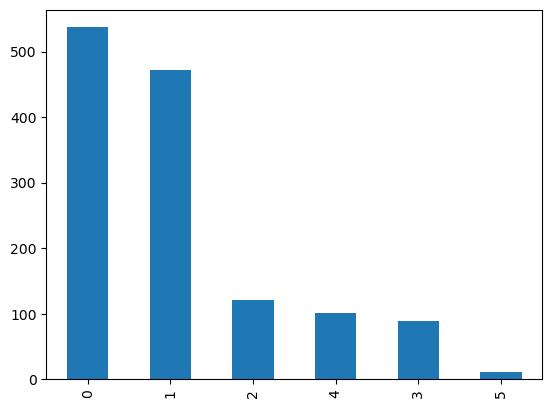

In [4]:
data = df["emotion"]
data.value_counts().plot.bar()
plt.show()

In [5]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [6]:
df['comment'] = df['comment'].apply(lambda row: emoji_pattern.sub(r'', row))
df

,comment,emotion
0,Jak palion zrobi piosenkę to wiadomo co będzie...,0
1,"Wiem, że palion może tego nigdy nie zobaczyć, ...",0
2,Był kiedyś taki serial : Kasia i Tomek i wedłu...,0
3,Mamy właśnie przykład jak powinna wyglądać pra...,0
4,Siemka WK teraz moja kolej na nagrodę pozdraw...,0
...,...,...
1327,Uwielbiam twoje firmy zabieram się za oglądani...,0
1328,"Dla mnie ""Film o pszczołach"" był genialny. Zar...",3
1329,Zawsze o 14.00 odrazu każda sobota jest lepsza...,0
1330,Zawsze oglądane do końca! La Budda <3,1


In [7]:
df['tokens'] = df['comment'].apply(spacy_tokenizer)
df['joined_tokens'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))
df.to_json('./../data/polish_translated/emotions/assignments_dataset_pl_with_tokens.json')

In [7]:
tokenized_sentences_df = pd.read_json(
    './../data/polish_translated/emotions/assignments_dataset_pl_with_tokens.json')
tokenized_sentences_df

,comment,emotion,tokens,joined_tokens
0,Jak palion zrobi piosenkę to wiadomo co będzie...,0,"[palion, zrobić, piosenka, wiadomo, kanał, poz...",palion zrobić piosenka wiadomo kanał pozdrawia...
1,"Wiem, że palion może tego nigdy nie zobaczyć, ...",0,"[wiedzieć, palion, móc, nie, zobaczyć, zrobić,...",wiedzieć palion móc nie zobaczyć zrobić chcieć...
2,Był kiedyś taki serial : Kasia i Tomek i wedłu...,0,"[kiedyś, serial, kasia, tomek, jesteście, nowo...",kiedyś serial kasia tomek jesteście nowoczesny...
3,Mamy właśnie przykład jak powinna wyglądać pra...,0,"[mieć, przykład, wyglądać, prawdziwy, konferen...",mieć przykład wyglądać prawdziwy konferencja w...
4,Siemka WK teraz moja kolej na nagrodę pozdraw...,0,"[siemka, wk, kolej, nagroda, pozdrawiać]",siemka wk kolej nagroda pozdrawiać
...,...,...,...,...
1327,Uwielbiam twoje firmy zabieram się za oglądani...,0,"[uwielbiam, firma, zabierać, oglądać, pozdrawi...",uwielbiam firma zabierać oglądać pozdrawiać ws...
1328,"Dla mnie ""Film o pszczołach"" był genialny. Zar...",3,"[film, pszczoł, genialny, zarówno, całokształt...",film pszczoł genialny zarówno całokształt swój...
1329,Zawsze o 14.00 odrazu każda sobota jest lepsza...,0,"[14, 00, odraz, sobota, dobry, dzięki, kamil, ...",14 00 odraz sobota dobry dzięki kamil ❤ ️
1330,Zawsze oglądane do końca! La Budda <3,1,"[oglądać, koniec, la, budda, <3]",oglądać koniec la budda <3


In [8]:
emotions = [0, 1]
rslt_df = tokenized_sentences_df[tokenized_sentences_df['emotion'].isin(emotions)]

In [9]:
len(rslt_df)

1009

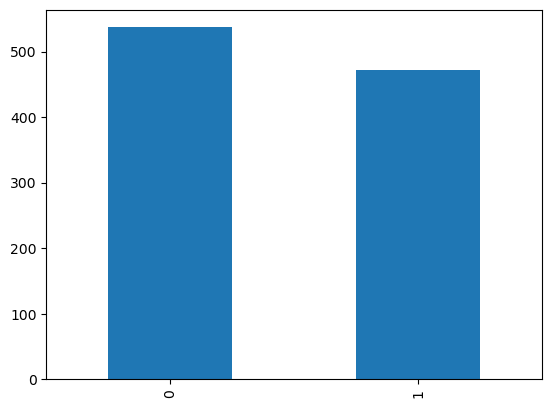

In [10]:
data = rslt_df["emotion"]
data.value_counts().plot.bar()
plt.show()

In [11]:
full_dataset = Dataset.from_pandas(rslt_df).remove_columns("__index_level_0__")
full_dataset

Dataset({
    features: ['comment', 'emotion', 'tokens', 'joined_tokens'],
    num_rows: 1009
})

In [12]:
# Train set: 80%, Validation set: 10%, Test set: 10%
train_dataset, val_dataset, test_dataset = model_utils.split_train_val_test(
    full_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [13]:
# Word2Vec
tokenized_sentences = train_dataset['tokens']
w2v_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=100, window=6, min_count=1)
w2v_model.train(tokenized_sentences, epochs=10, total_examples=len(tokenized_sentences))

(77205, 84740)

In [14]:
def tokens_to_vector(tokens):
    vector_size = w2v_model.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in tokens:
        if w in w2v_model.wv:
            ctr += 1
            wv_res += w2v_model.wv[w]
    wv_res = wv_res / ctr
    return wv_res

In [15]:
def tokenize_for_word2vec(sample):
    sample['embeddings'] = [tokens_to_vector(tokens) for tokens in sample['tokens']]
    return sample


train_dataset = train_dataset.map(tokenize_for_word2vec, batched=True)
val_dataset = val_dataset.map(tokenize_for_word2vec, batched=True)
test_dataset = test_dataset.map(tokenize_for_word2vec, batched=True)

Map:   0%|          | 0/807 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

In [16]:
columns = ["embeddings"]
label_cols = ["emotion"]
batch_size = 16

tf_train_dataset = model_utils.convert_to_tf_dataset(train_dataset, columns, label_cols, None, batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(val_dataset, columns, label_cols, None, batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(test_dataset, columns, label_cols, None, batch_size)

c:\Users\Artur\.conda\envs\nlp\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [68]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [69]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [70]:
# Model parameters
training_number = 1
model_name = 'emotions_pl_word2vec_binary_thesis'
training_name = f"training_{training_number}"
figures_dir = f"./../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [71]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [72]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=20,
                    callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/20


44/51 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.5355
Epoch 1: saving model to ./../training_checkpoints\emotions_pl_word2vec_binary_thesis\training_1\cp-0001.ckpt
51/51 [==============================] - 1s 10ms/step - loss: 0.6927 - accuracy: 0.5378 - val_loss: 0.6898 - val_accuracy: 0.5248
Epoch 2/20
43/51 [========================>.....] - ETA: 0s - loss: 0.6913 - accuracy: 0.5363
Epoch 2: saving model to ./../training_checkpoints\emotions_pl_word2vec_binary_thesis\training_1\cp-0002.ckpt
51/51 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5378 - val_loss: 0.6938 - val_accuracy: 0.5248
Epoch 3/20
49/51 [===========================>..] - ETA: 0s - loss: 0.6895 - accuracy: 0.5357
Epoch 3: saving model to ./../training_checkpoints\emotions_pl_word2vec_binary_thesis\training_1\cp-0003.ckpt
51/51 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5353 - val_loss: 0.6967 - val_accuracy: 0.5248
Epoch 4/20


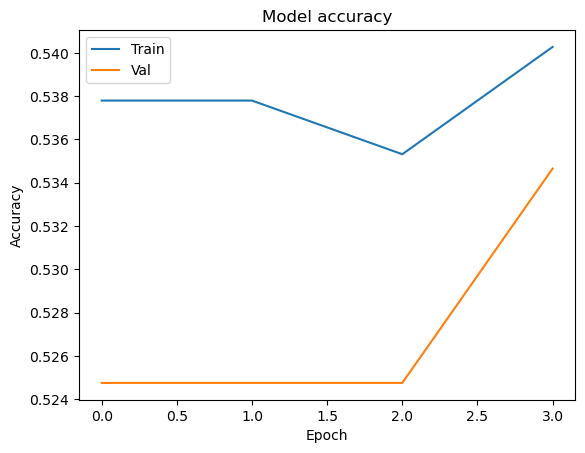

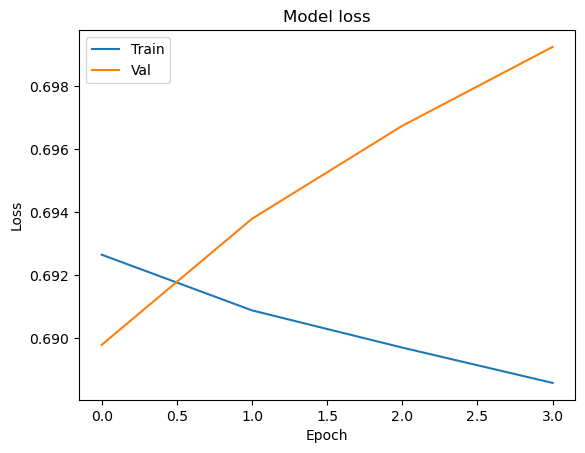

In [73]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [74]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [75]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ./../trained_models\emotions_pl_word2vec_binary_thesis_1\1\assets


In [76]:
w2v_model.save(f"./word2vec/{model_name}_{training_number}.model")

In [77]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

7/7 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.4950


[0.6951421499252319, 0.49504950642585754]

In [78]:
class_preds = model_utils.get_class_preds(best_model, tf_test_dataset, model_returns_logits=False)

7/7 [==============================] - 0s 2ms/step


In [79]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['emotion'],
    class_preds=class_preds,
    average='micro'
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.49504950495049505
Recall score:  0.49504950495049505
F1 score:  0.49504950495049505


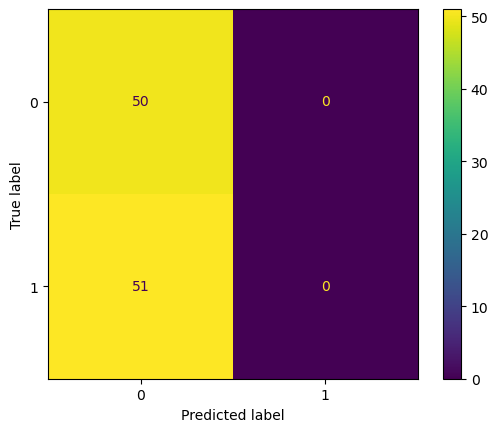

In [80]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['emotion'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [30]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['comment'],
                                              class_actual=test_dataset['emotion'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: Dojebane jak każdy Wasz kawałek ! Panowie czekam na koncert w Białymstoku, pozdro ✌
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: Mistrz! Idealne przed snem po calym dniu 
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: Miszczostwo świata, pełen szacunek za tekst 
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 6
            - TEXT: Rozjebane teraz czekamy na wspólną płytkę ❤️
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 7
            - TEXT: Tą reklamę powinni puścić w telewizji 
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            


In [31]:
test_df = pd.DataFrame(
    list(zip(test_dataset['comment'], test_dataset['emotion'], class_preds)),
    columns=['comment', 'emotion', 'prediction'])
test_df

,comment,emotion,prediction
0,"solidny imprezowy numer, nie ma się do czego p...",0,0
1,Dojebane jak każdy Wasz kawałek ! Panowie czek...,1,0
2,Na uwagę zasługuje fakt ze Sanah jako jedna z ...,0,0
3,Mistrz! Idealne przed snem po calym dniu,1,0
4,"Miszczostwo świata, pełen szacunek za tekst",1,0
...,...,...,...
96,Witaj tato ❤ Zdrowia dla Waszej trójki. Cudown...,0,0
97,Oboję musicie iść na TOP MODEL ❤❤❤,1,0
98,Dlatych co nie chcą czekać 5 lat mają taki kol...,0,0
99,Jak dla mnie najlepszy kawałek na tej płycie 🤯,1,0


In [32]:
def map_token_counts(row):
    return len(row['comment'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['emotion'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,comment,emotion,prediction,token_count,count_belonging,correctly_predicted
0,"solidny imprezowy numer, nie ma się do czego p...",0,0,10,6-11,1
1,Dojebane jak każdy Wasz kawałek ! Panowie czek...,1,0,14,12-17,0
2,Na uwagę zasługuje fakt ze Sanah jako jedna z ...,0,0,70,66-71,1
3,Mistrz! Idealne przed snem po calym dniu,1,0,7,6-11,0
4,"Miszczostwo świata, pełen szacunek za tekst",1,0,6,6-11,0
...,...,...,...,...,...,...
96,Witaj tato ❤ Zdrowia dla Waszej trójki. Cudown...,0,0,10,6-11,1
97,Oboję musicie iść na TOP MODEL ❤❤❤,1,0,7,6-11,0
98,Dlatych co nie chcą czekać 5 lat mają taki kol...,0,0,14,12-17,1
99,Jak dla mnie najlepszy kawałek na tej płycie 🤯,1,0,9,6-11,0


In [33]:
test_df = test_df.drop(test_df[test_df.token_count > 41].index)

In [34]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

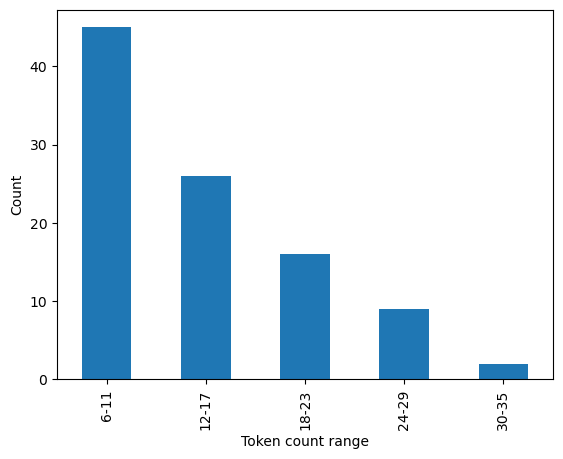

In [35]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [36]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0., '24-29': 0., '30-35': 0., '36-41': 0.}

In [37]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

ZeroDivisionError: division by zero

In [ ]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23', '24-29', '30-35', '36-41'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()